\newpage

# 0 Setup {-}

In [1]:
# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
# imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, datasets

In [3]:
# ignore tensorflow depreciation warnings
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

### 0.1 Visualizing the Dataset {-}

In [4]:
# given by the assignment
def loadData():
    with np.load("notMNIST.npz") as data:
        Data, Target = data ["images"], data["labels"]
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx]/255.
        Target = Target[randIndx]
        trainData, trainTarget = Data[:15000], Target[:15000]
        validData, validTarget = Data[15000:16000], Target[15000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

\newpage

In [29]:
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
print(f"Training Data: {trainData.shape}\tTraining tagets: {trainTarget.shape}")
print(f"Validation Data: {validData.shape}\tValidation tagets: {validTarget.shape}")
print(f"Testing Data: {testData.shape}\tTesting tagets:{testTarget.shape}")

Training Data: (15000, 28, 28)	Training tagets: (15000,)
Validation Data: (1000, 28, 28)	Validation tagets: (1000,)
Testing Data: (2724, 28, 28)	Testing tagets:(2724,)


In [6]:
def plot(image, target, ax=None):
    ax = plt.gca() if ax == None else ax
    ax.imshow(image, cmap=plt.cm.gray)
    target_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
    ax.set_title(target_names[target])
    # targets interger encoded from 0 to 9 corresponding to 'A' to 'J', respectively

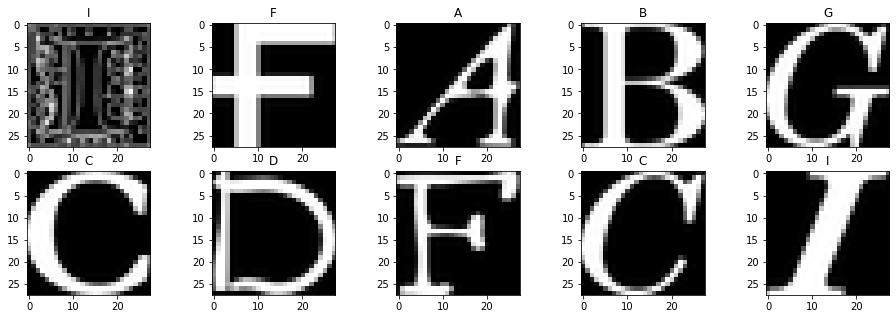

In [7]:
fig, axis = plt.subplots(2, 5, figsize=(16, 5))
for ax in axis.reshape(-1):
    r = np.random.randint(trainData.shape[0])
    plot(trainData[r], trainTarget[r], ax=ax)
plt.show()

\newpage

### 0.2 Useful Functions {-}

Some useful functions that will be used throughout the assignment such as getting random weights, getting the accuracy of a batch, making the loss and accuracy plots look nice, and global variables used throughout the code

In [8]:
# given by the assignment
def convertOneHot(trainTarget, validTarget, testTarget):
    newtrain = np.zeros((trainTarget.shape[0], 10))
    newvalid = np.zeros((validTarget.shape[0], 10))
    newtest = np.zeros((testTarget.shape[0], 10))
    for item in range(0, trainTarget.shape[0]):
        newtrain[item][trainTarget[item]] = 1
    for item in range(0, validTarget.shape[0]):
        newvalid[item][validTarget[item]] = 1
    for item in range(0, testTarget.shape[0]):
        newtest[item][testTarget[item]] = 1
    return newtrain, newvalid, newtest

In [24]:
def accuracy(y_pred, y):
    if y_pred.shape != y.shape:
        raise ValueError(f"prediction dimension {y_pred.shape} and label dimensions {y.shape} don't match")
    return np.sum(y_pred.argmax(axis=1) == y.argmax(axis=1)) / y.shape[0]

In [48]:
def plot_loss(x, train_loss=None, valid_loss=None, test_loss=None, title=None, ax=None):
    ax = plt.gca() if ax == None else ax
    if train_loss != None:
        ax.plot(x, train_loss, label="Training Loss")
    if valid_loss != None:
        ax.plot(x, valid_loss, label="Validation Loss")
    if test_loss != None:
        ax.plot(x, test_loss, label="Testing Loss")
    
    ax.set_title("Loss" if title == None else title)
    
    ax.set_xlabel("Iterations")
    ax.set_xlim(left=0)
    ax.set_ylabel("Loss")
    ax.set_ylim(bottom=0)
    ax.legend(loc="upper right")

def plot_accuracy(x, train_accuracy=None, valid_accuracy=None, test_accuracy=None, title=None, ax=None):
    ax = plt.gca() if ax == None else ax
    if train_accuracy != None:
        ax.plot(x, train_accuracy, label="Training Accuracy")
    if valid_accuracy != None:
        ax.plot(x, valid_accuracy, label="Validation Accuracy")
    if test_accuracy != None:
        ax.plot(x, test_accuracy, label="Testing Accuracy")
    
    ax.set_title("Accuracy" if title == None else title)

    ax.set_xlabel("Iterations")
    ax.set_xlim(left=0)
    ax.set_ylabel("Accuracy")
    ax.set_yticks(np.arange(0, 1.1, step=0.1))
    ax.grid(linestyle='-', axis='y')
    ax.legend(loc="lower right")
    

def display_statistics(train_loss=None, train_acc=None, valid_loss=None, valid_acc=None, 
                       test_loss=None, test_acc=None):
    
    tl = "-" if train_loss is None else round(train_loss[-1], 4)
    ta = "-" if train_acc is None else round(train_acc[-1]*100, 2)
    vl = "-\t" if valid_loss is None else round(valid_loss[-1], 4)
    va = "-" if valid_acc is None else round(valid_acc[-1]*100, 2)
    sl = "-\t\t" if test_loss is None else round(test_loss[-1], 4)
    sa = "-" if test_acc is None else round(test_acc[-1]*100, 2)
    
    print(f"Training loss: {tl}{'':.20s}\t\tTraining acc: {ta}{'%' if ta != '-' else ''}")
    print(f"Validation loss: {vl}{'':.20s}\tValidation acc: {va}{'%' if va != '-' else ''}")
    print(f"Testing loss: {sl}{'':.20s}\tTesting acc: {sa}{'%' if sa != '-' else ''}")
    
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    plot_loss(np.arange(0, len(train_loss), 1), train_loss, valid_loss, test_loss, ax=ax[0])
    plot_accuracy(np.arange(0, len(train_loss), 1), train_acc, valid_acc, test_acc, ax=ax[1])
    plt.show()
    plt.close()

In [49]:
TINY = 1e-20
VTDatasets = {"validData" : validData, "validTarget" : validTarget,
              "testData" : testData, "testTarget" : testTarget}

N = trainData.shape[0]
d = trainData.shape[1] * trainData.shape[2]
K = 10

\newpage

# 1 Neural Networks using Numpy {-}
### 1.1 Helper Functions {-}

In [13]:
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    return np.exp(x) / np.exp(x).sum()

def softmax_batch(X):
    return np.exp(X) / np.exp(X).sum(axis=1, keepdims=True)

In [14]:
def computeLayer(X, W, b):
    # W might need to get transposed depending on how we define it
    return X.dot(W) + b

In [51]:
# target is one-hot encoded
def CE(target, prediction):
    return -(target * np.log(prediction+TINY)).sum(axis=1).mean()

# target is one-hot encoded
def gradCE(target, predication):
    return predication - target

### 1.2 Backpropagation Derivation {-} 

#### Derivative of Softmax

$p_i = \texttt{softmax}(\textbf{o})_i = \frac{e^{o_i}}{\sum_{k=1}^K e^{o_k}}$

$\quad \quad \quad \text{if  } i \neq j$
$$\frac{\partial p_j}{\partial o_i} = \frac{0 \cdot \sum_{k=1}^K e^{o_k} - e^{o_i} \cdot e^{o_j}}{(\sum_{k=1}^K e^{o_k})^2} = \boxed{- p_i \cdot p_j}$$

$\quad \quad \quad \text{if  } i = j$
$$\frac{\partial p_j}{\partial o_i} = \frac{e^{o_i} \cdot \sum_{k=1}^K e^{o_k} - e^{o_i} \cdot e^{o_j}}{(\sum_{k=1}^K e^{o_k})^2} = \boxed{(1 - p_j) \cdot p_i}$$

#### Derivative of Softmax + Cross Entropy Loss

$$L_{CE}(\textbf{y}, \textbf{p}) = -\sum_{k=1}^{K} y_k \log{p_k}$$

$$ \frac{\partial L_{CE}}{\partial o_i} =  -\sum_{k=1}^{K} \frac{y_k}{p_k} \cdot \frac{\partial p_k}{\partial o_i} = -y_i(1 - p_i) - \sum_{k \neq i} \frac{y_k}{p_k} \cdot (-p_k p_i) = -y_i + y_ip_i + \sum_{k \neq i} y_k p_i = -y_i + p_i \cdot \sum_{k=1}^K y_k = p_i - y_i$$

In Vector Form: $\boxed{\frac{\partial L_{CE}}{\partial \textbf{o}} = \textbf{p} - \textbf{y}}$

#### Remaining Backpropogation

$\textbf{o} = W_o \textbf{g} + \textbf{b}_o$

$$\frac{\partial L}{\partial W_o} = \frac{\partial L}{\partial \textbf{o}} \cdot (\frac{\partial \textbf{o}}{\partial W_o})^T = \frac{\partial L}{\partial \textbf{o}} \cdot \textbf{g}^T$$

$$\frac{\partial L}{\partial \textbf{b}_o} = \frac{\partial L}{\partial \textbf{o}} \cdot (\frac{\partial \textbf{o}}{\partial \textbf{b}_o})^T = \frac{\partial L}{\partial \textbf{o}}$$

$g_i = \texttt{ReLU}(h_i) = \texttt{max}(h_i, 0)$

$$\frac{\partial L}{\partial h_i} = \frac{\partial L}{\partial g_i} \cdot \frac{\partial g_i}{\partial h_i} = \frac{\partial L}{\partial g_i} \cdot \begin{cases} 1 &\text{if } h_1 > 0 \\ 0 &\text{if } h_i < 0 \end{cases}$$

$\textbf{h} = W_h \textbf{x} + \textbf{b}_h$

$$\frac{\partial L}{\partial W_h} = \frac{\partial L}{\partial \textbf{h}} \cdot (\frac{\partial \textbf{h}}{\partial W_h})^T = \frac{\partial L}{\partial \textbf{h}} \cdot \textbf{x}^T$$

$$\frac{\partial L}{\partial \textbf{b}_h} = \frac{\partial L}{\partial \textbf{h}} \cdot (\frac{\partial \textbf{h}}{\partial \textbf{b}_h})^T = \frac{\partial L}{\partial \textbf{h}}$$

### 1.3 Learning {-}

epoch 1
epoch 2	loss: 41.3744	acc: 0.0824
epoch 3	loss: 41.4467	acc: 0.1005
epoch 4	loss: 41.4466	acc: 0.1005
epoch 5	loss: 41.4466	acc: 0.1005
epoch 6	loss: 41.4466	acc: 0.1005
epoch 7	loss: 41.4466	acc: 0.1005
epoch 8	loss: 41.4466	acc: 0.1005
epoch 9	loss: 41.4466	acc: 0.1005
epoch 10	loss: 41.4466	acc: 0.1005
Training loss: 41.4466		Training acc: 10.05%
Validation loss: -		Validation acc: -
Testing loss: -			Testing acc: -


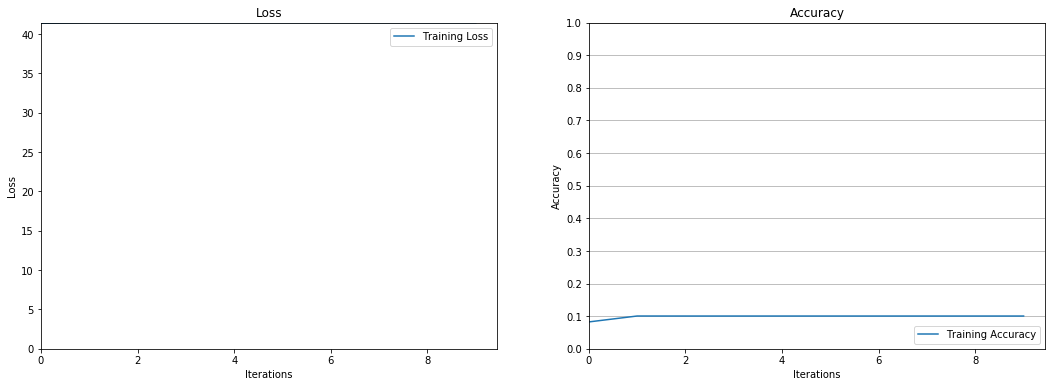

In [57]:
class mini_NN(object):

    """ 
    input:  x
    hidden: h = W_h * x + b_h
            g = ReLU(h)
    output: o = W_o * g + b_o
            p = softmax(o)
    """

    def __init__(self, D, F, K):
        self.D = D
        self.F = F
        self.K = K

    def init_weights(self):
        # getting random parameters using Xaiver initialization scheme
        self.W_h = np.random.normal(0, np.sqrt(2.0/(self.D+self.F)), (self.D, self.F))
        self.b_h = np.random.normal(0, np.sqrt(2.0/(self.D+self.F)), self.F) 
        self.W_o = np.random.normal(0, np.sqrt(2.0/(self.F+self.K)), (self.F, self.K))
        self.b_o = np.random.normal(0, np.sqrt(2.0/(self.F+self.K)), self.K)
    
    def feedforward(self, X):
        # python can dynamically create attributes
        self.H = computeLayer(X, self.W_h, self.b_h)
        self.G = relu(self.H)
        self.O = computeLayer(self.G, self.W_o, self.b_o)
        self.P = softmax_batch(self.O)
        return self.P
    
    def backpropagation(self, X, y):
        
        # This function assumes that feedforward was called before, 
        # which instantiates the needed activations
        
        # output layer activations
        dL_do = gradCE(y, self.O)

        # output layer parameters
        dL_dWo = self.G.T @ dL_do
        dL_dbo = dL_do

        # hidden layer activations
        dL_dg = dL_do @ self.W_o.T
        dL_dh = ((dL_dg > 0) * 1).astype(np.float64)

        # hidden layer parameters
        dL_dWh = X.T @ dL_dh
        dL_dbh = dL_dh
        
        return dL_dWo.mean(axis=0), dL_dbo.mean(axis=0), dL_dWh.mean(axis=0), dL_dbh.mean(axis=0)

    def train(self, X, y, epochs=200, gamma=0.99, alpha=1e-5, F=1000,
             validData=None, validTarget=None, testData=None, testTarget=None):
        # initializations
        self.F = F
        self.init_weights()
        
        train_loss, train_acc = [], []
        valid_loss, valid_acc = [], []
        test_loss, test_acc = [], []
        
        v_Wo = v_bo = v_Wh = v_bh = 0
        
        for e in range(epochs):
            if e > 0:
                print(f"epoch {e+1}\tloss: {train_loss[-1]:.4f}\tacc: {train_acc[-1]:.4f}")
            else:
                print("epoch", e+1)
            
            p = self.feedforward(X)
            train_loss.append( CE(p, y) )
            train_acc.append( accuracy(p, y) )
            
            dL_dWo, dL_dbo, dL_dWh, dL_dbh = self.backpropagation(X, y)
            
            v_Wo = gamma * v_Wo + alpha * dL_dWo
            self.W_o -= v_Wo
            
            v_bo = gamma * v_bo + alpha * dL_dbo
            self.b_o -= v_bo
            
            v_Wh = gamma * v_Wh + alpha * dL_dWh
            self.W_h -= v_Wh
            
            v_bh = gamma * v_bh + alpha * dL_dbh
            self.b_h -= v_bh
        
        statistics = (train_loss, train_acc)
        if not validData is None and not validTarget is None:
            statistics += (valid_loss, valid_acc, )
        if not testData is None and not testTarget is None:
            statistics += (test_loss, test_acc,)
        return statistics

X = trainData.reshape(N, d)
newtrain, newvalid, newtest = convertOneHot(trainTarget, validTarget, testTarget)

model = mini_NN(d, 100, K)
statistics = model.train(X, newtrain, epochs=10)
display_statistics(*statistics)

### 1.4 Hyperparameter Investigation {-}

\newpage

# 2 Neural Networks in Tensorflow {-}
### 2.1 Model implementation {-}

In [19]:
# load data
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
trainData = trainData.reshape(15000,28,28,1)
# one-hot encode
train_labels, valid_labels, test_labels = convertOneHot(trainTarget, validTarget, testTarget)

# training params
epochs = 50
learning_rate = 0.0001
batch_size = 32

# create model
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(28, 28,1)))    # input layer
model.add(layers.Conv2D(                                                        # conv layer
        filters=32,
        strides=(1,1),
        kernel_size=[3, 3],
        padding="same",
        activation='relu',
        kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False)))
model.add(layers.BatchNormalization())                                          # batch norm
model.add(layers.MaxPooling2D((2, 2)))                                          # max pooling
model.add(layers.Flatten())                                                     # flatten
model.add(layers.Dense(784, activation='relu'))                                 # fully-connected 784 w/ ReLu
model.add(layers.Dense(10))                                                     # fully-connected 10
model.add(layers.Softmax())                                                     # softmax output

# print model summary
# model.summary()

# compile model w/ Adam optimizer + cross entropy loss
model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# train
history = model.fit(trainData, train_labels, epochs=epochs, batch_size=batch_size)

# plot accuracy per epoch
# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
# plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

### 2.2 Model Training {-}

### 2.3 Hyperparameter Investigation {-}